In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

In [2]:
data_train=pd.read_csv('train_data.csv')
data_test=pd.read_csv('test_data.csv')

In [3]:
print("The shape of the Training set: ", data_train.shape)
print("The shape of the Testing set: ", data_test.shape)

The shape of the Training set:  (169307, 43)
The shape of the Testing set:  (91166, 42)


Text(0.5,0,'Target Class')

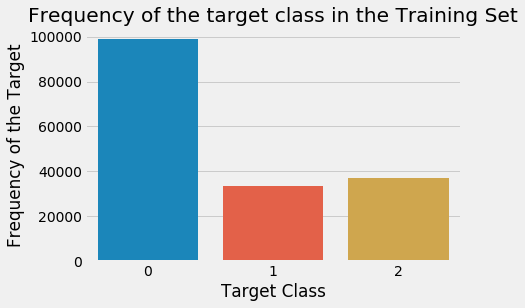

In [4]:
import matplotlib.style as style
style.use('fivethirtyeight')
sns.countplot(x="target", data=data_train)
plt.title('Frequency of the target class in the Training Set')
plt.ylabel('Frequency of the Target')
plt.xlabel('Target Class')

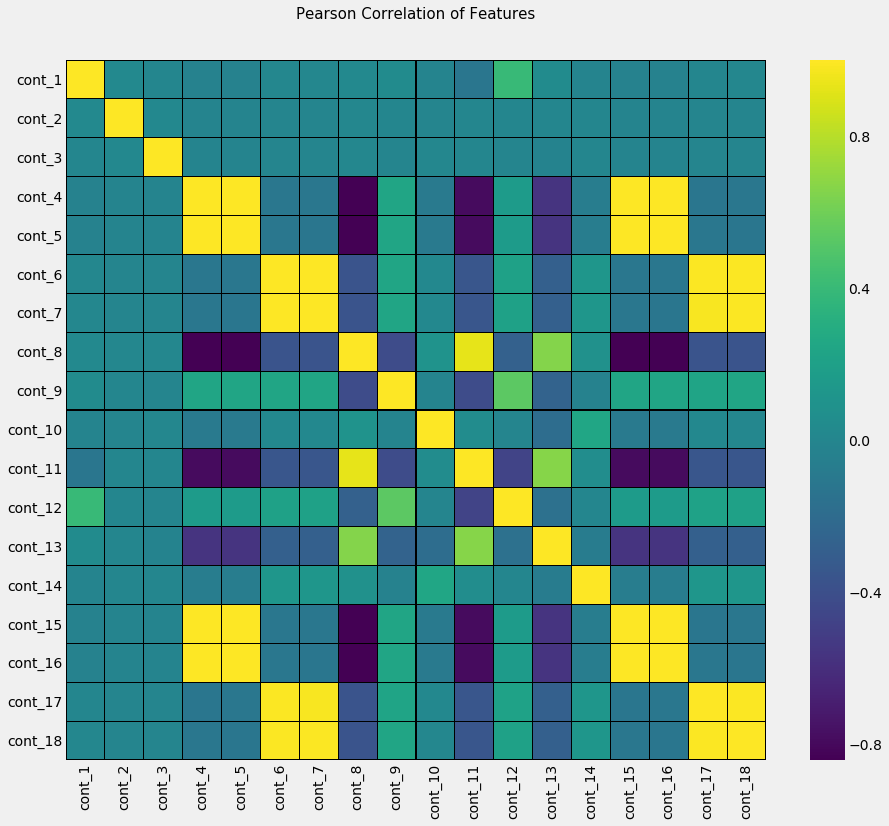

In [5]:
data_train_num=data_train.drop(['connection_id','cat_1','cat_2','cat_3','cat_4','cat_5','cat_6','cat_7','cat_8','cat_9','cat_10','cat_11','cat_12','cat_13','cat_14','cat_15','cat_16','cat_17','cat_18','cat_19','cat_20','cat_21','cat_22','cat_23','target'],axis=1)
colormap = plt.cm.viridis
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(data_train_num.astype(float).corr(),linewidths=0.05,vmax=1.0, square=True, cmap=colormap, linecolor='black', annot=False)

In [6]:
def prox_matrix(df, target, features, cluster_dimension,trees = 10):
    #https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm#prox

    from sklearn.ensemble import RandomForestClassifier
    import numpy as np
    import pandas as pd

    #initialize datframe for independant variables
    independant = pd.DataFrame()

    #Handle Categoricals: This should really be added to RandomForestRegressor
    for column,data_type in df[features].dtypes.iteritems():       
        try:
            independant[column] = pd.to_numeric(df[column],downcast = 'integer')
        except ValueError:
            contains_nulls = df[column].isnull().values.any()
            dummies = pd.get_dummies(df[column],prefix=column,dummy_na=contains_nulls,drop_first=True)
            independant[dummies.columns] = dummies

    if len(independant.index) != len(df.index):
        raise Exception('independant variables not stored properly')

    #train Model    
    clf = RandomForestClassifier(n_estimators=trees, n_jobs=-1)
    clf.fit(independant, df[target])

    #Final leaf for each tree
    leaves = clf.apply(independant)
    #value in cluster dimension
    labels = df[cluster_dimension].values

    numerator_matrix = {}
    for i,value_i in enumerate(labels):
        for j,value_j in enumerate(labels):
            if i >= j:       
                numerator_matrix[(value_i,value_j)] = numerator_matrix.get((value_i,value_j), 0) + np.count_nonzero(leaves[i]==leaves[j])
                numerator_matrix[(value_j,value_i)] = numerator_matrix[(value_i,value_j)] 

    #normalize by the total number of possible matchnig leaves        
    prox_matrix = {key: 1.0 - float(x)/(trees*np.count_nonzero(labels==key[0])*np.count_nonzero(labels==key[1])) for key, x in numerator_matrix.iteritems()}                                                                  

    #make sorted dataframe                                                                                                                                                                                                                                                                
    levels = np.unique(labels)
    D = pd.DataFrame(data=[[ prox_matrix[(i,j)] for i in levels] for j in levels],index=levels,columns=levels)

    return D

In [7]:
def kMedoids(D, k, tmax=100):
    #https://www.researchgate.net/publication/272351873_NumPy_SciPy_Recipes_for_Data_Science_k-Medoids_Clustering
    import numpy as np
    import pandas as pd

    # determine dimensions of distance matrix D
    m, n = D.shape

    if m != n:
        raise Exception('matrix not symmetric')

    if sum(D.columns.values != D.index.values):
        raise Exception('rows and columns do not match')

    if k > n:
        raise Exception('too many medoids')

    #Some distance matricies will not have a 0 diagonal    
    Dtemp =D.copy()
    np.fill_diagonal(Dtemp.values,0)

    # randomly initialize an array of k medoid indices
    M = list(Dtemp.sample(k).index.values)

    # initialize a dictionary to represent clusters
    Cnew = {}

    for t in xrange(tmax):    
        # determine mapping to clusters
        J = Dtemp.loc[M].idxmin(axis='index')
        #Fill dictionary with cluster members
        C = {kappa: J[J==kappa].index.values for kappa in J.unique()}  
        # update cluster medoids
        Cnew = {Dtemp.loc[C[kappa],C[kappa]].mean().idxmin() : C[kappa] for kappa in C.keys()}       
        #Update mediod list
        M = Cnew.keys()

        # check for convergence (ie same clusters)
        if set(C.keys()) == set(Cnew.keys()):
            if not sum(set(C[kappa]) != set(Cnew[kappa]) for kappa in C.keys()): break            
    else:        
        print('did not converge')

    #Calculate silhouette 
    S = {}
    for kappa_same in Cnew.keys():
        a = Dtemp.loc[Cnew[kappa_same],Cnew[kappa_same]].mean().mean()
        b = np.min([Dtemp.loc[Cnew[kappa_other],Cnew[kappa_same]].mean().mean() for kappa_other in Cnew.keys() if kappa_other!=kappa_same])
        S[kappa_same] = (b - a) / max(a, b)

    # return results
    return M, Cnew, S

In [8]:
X_total=data_train.drop('target',axis=1)
X_total=X_total.append(data_test)
X_test=data_test[['connection_id']]

In [9]:
X_train=data_train[['connection_id']]

In [10]:
X_total_num=X_total.drop(['connection_id','cat_1','cat_2','cat_3','cat_4','cat_5','cat_6','cat_7','cat_8','cat_9','cat_10','cat_11','cat_12','cat_13','cat_14','cat_15','cat_16','cat_17','cat_18','cat_19','cat_20','cat_21','cat_22','cat_23'],axis=1)

In [11]:
X_total.shape

(260473, 42)

In [12]:
data_train_num=data_train.drop(['connection_id','cat_1','cat_2','cat_3','cat_4','cat_5','cat_6','cat_7','cat_8','cat_9','cat_10','cat_11','cat_12','cat_13','cat_14','cat_15','cat_16','cat_17','cat_18','cat_19','cat_20','cat_21','cat_22','cat_23','target'],axis=1)
data_test_num=data_test.drop(['connection_id','cat_1','cat_2','cat_3','cat_4','cat_5','cat_6','cat_7','cat_8','cat_9','cat_10','cat_11','cat_12','cat_13','cat_14','cat_15','cat_16','cat_17','cat_18','cat_19','cat_20','cat_21','cat_22','cat_23'],axis=1)

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [14]:
X_train_num_scld=StandardScaler().fit_transform(data_train_num)
X_test_num_scld=StandardScaler().fit_transform(data_test_num)

In [15]:
pca=PCA()
pca2=PCA()
X_train_num_trf=pca.fit_transform(X_train_num_scld)
X_test_num_trf=pca2.fit_transform(X_test_num_scld)

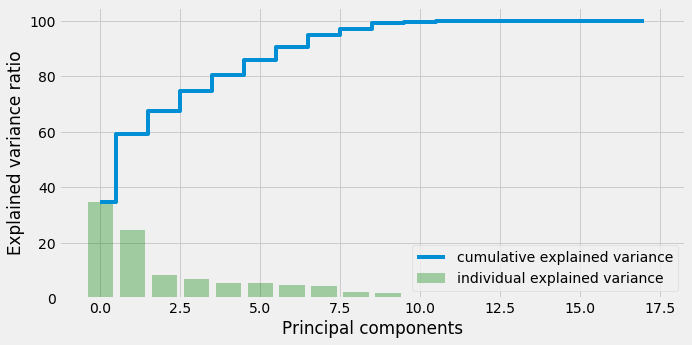

In [16]:
var=(pca.explained_variance_)
tot=sum(var)
var_exp = [(i/tot)*100 for i in sorted(var, reverse=True)] # Individual explained variance

exp_var_ratio=pca.explained_variance_ratio_
cum_var=np.cumsum(exp_var_ratio*100)

# PLOT OUT THE EXPLAINED VARIANCES SUPERIMPOSED 
plt.figure(figsize=(10, 5))
plt.bar(range(18), var_exp, alpha=0.3333, align='center', label='individual explained variance', color = 'g')
plt.step(range(18), cum_var, where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show()

In [17]:
pca=PCA(n_components=10)
X_train_num_trf_10d=pca.fit_transform(X_train_num_scld)
X_train_pca=pd.DataFrame(X_train_num_trf_10d,columns=['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10'])

In [18]:
pca2=PCA(n_components=10)
X_test_num_trf_10d=pca.fit_transform(X_test_num_scld)
X_test_pca=pd.DataFrame(X_test_num_trf_10d,columns=['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10'])

In [19]:
del X_train_num_trf
del X_train_num_trf_10d
del X_test_num_trf
del X_test_num_trf_10d

In [20]:
X_train_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,-1.526824,-0.273090,0.055980,-0.370688,-0.013640,-0.011342,-0.023437,0.121546,-0.255491,0.120225
1,-1.526767,-0.273085,0.055472,-0.371114,-0.022053,-0.003077,-0.022022,0.121603,-0.255331,0.120371
2,-1.526824,-0.273090,0.055980,-0.370688,-0.013640,-0.011342,-0.023437,0.121546,-0.255491,0.120225
3,-1.526824,-0.273090,0.055980,-0.370688,-0.013640,-0.011342,-0.023437,0.121546,-0.255491,0.120225
4,-1.526824,-0.273090,0.055980,-0.370688,-0.013640,-0.011342,-0.023437,0.121546,-0.255491,0.120225


In [21]:
X_test_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,-0.924014,-0.169952,0.165744,-0.285230,0.113625,-0.089368,-0.400043,-1.480095,-0.379930,-0.210480
1,-1.524722,-0.271372,-0.044706,0.068415,-0.362890,-0.017348,0.122403,0.260594,0.109133,0.006373
2,-1.524724,-0.271371,-0.043494,0.068362,-0.362953,-0.017374,0.122428,0.260691,0.109144,0.006299
3,-1.524724,-0.271371,-0.043494,0.068362,-0.362953,-0.017374,0.122428,0.260691,0.109144,0.006299
4,-1.524724,-0.271371,-0.043494,0.068362,-0.362953,-0.017374,0.122428,0.260691,0.109144,0.006299


In [22]:
X_total_cat=pd.DataFrame(X_total,columns=['cat_1','cat_2','cat_3','cat_4','cat_5','cat_6','cat_7','cat_8','cat_9','cat_10','cat_11','cat_12','cat_13','cat_14','cat_15','cat_16','cat_17','cat_18','cat_19','cat_20','cat_21','cat_22','cat_23'],dtype=str)

In [23]:
for col_name in X_total_cat.columns:
    if X_total_cat[col_name].dtype=='object':
        unique_cat=len(X_total_cat[col_name].unique())
        print("Feature:- {col_name} has {unique_cat} unique categories".format(col_name=col_name,unique_cat=unique_cat))

Feature:- cat_1 has 3 unique categories
Feature:- cat_2 has 66 unique categories
Feature:- cat_3 has 11 unique categories
Feature:- cat_4 has 2 unique categories
Feature:- cat_5 has 3 unique categories
Feature:- cat_6 has 2 unique categories
Feature:- cat_7 has 19 unique categories
Feature:- cat_8 has 3 unique categories
Feature:- cat_9 has 2 unique categories
Feature:- cat_10 has 15 unique categories
Feature:- cat_11 has 2 unique categories
Feature:- cat_12 has 3 unique categories
Feature:- cat_13 has 13 unique categories
Feature:- cat_14 has 11 unique categories
Feature:- cat_15 has 3 unique categories
Feature:- cat_16 has 7 unique categories
Feature:- cat_17 has 1 unique categories
Feature:- cat_18 has 2 unique categories
Feature:- cat_19 has 2 unique categories
Feature:- cat_20 has 462 unique categories
Feature:- cat_21 has 431 unique categories
Feature:- cat_22 has 256 unique categories
Feature:- cat_23 has 256 unique categories


Text(0.5,0,'Target Class')

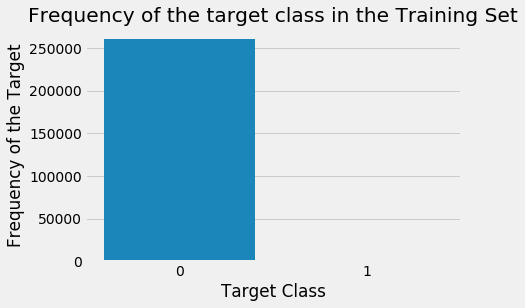

In [24]:
# cat_1--OK, cat_2--Not, cat_3--Not, cat_4--Not,cat_5--Not,cat_6--Not,cat_7-- not,cat_8--not,cat_9--Ok,cat_10--not, cat11--not,cat_12--not, cat_13--not,cat_14--not,cat_15--not,cat_16--not,cat_18-not,cat_19--not,cat_20
sns.countplot(x="cat_19", data=X_total_cat)
plt.title('Frequency of the target class in the Training Set')
plt.ylabel('Frequency of the Target')
plt.xlabel('Target Class')

In [25]:
print(X_total_cat['cat_17'].value_counts().sort_values(ascending=False).head(5))

0    260473
Name: cat_17, dtype: int64


In [26]:
for i in X_total_cat.columns:
    print(X_total_cat[i].value_counts().sort_values(ascending=False).head(20))

3    149935
1     99533
2     11005
Name: cat_1, dtype: int64
10    148841
13     58964
1      33121
2       5301
11      3751
3       2999
15      2162
7        832
5        366
6        339
14       311
8        295
12       258
4        201
9        198
20       108
36        72
47        72
42        68
24        65
Name: cat_2, dtype: int64
1     199586
8      44370
6      15622
9        447
7        338
11        53
3         22
4         13
2         10
10        10
5          2
Name: cat_3, dtype: int64
0    260470
1         3
Name: cat_4, dtype: int64
0    260406
3        47
1        20
Name: cat_5, dtype: int64
0    260472
2         1
Name: cat_6, dtype: int64
0     259939
2        227
1         80
4         49
6         44
5         25
19        16
22        16
14        16
30        15
18        13
24        11
28        10
3          6
20         2
13         1
12         1
10         1
21         1
Name: cat_7, dtype: int64
0    260427
1        45
3         1
Name: cat_8,

In [27]:
cat_less=['cat_4','cat_5','cat_6','cat_7','cat_8','cat_10','cat_11','cat_15','cat_17','cat_18']

In [28]:
print(X_total_cat['cat_2'].value_counts().sort_values(ascending=False).head(5))
print(X_total_cat['cat_16'].value_counts().sort_values(ascending=False).head(20))

10    148841
13     58964
1      33121
2       5301
11      3751
Name: cat_2, dtype: int64
0    260224
1       238
2         7
8         1
4         1
3         1
5         1
Name: cat_16, dtype: int64


In [29]:
#X_total_cat['target']=data_train['target']

In [30]:
#DF=prox_matrix(X_total_cat, 'target',list(X_total_cat.columns), ['cat_2','cat_3','cat_7','cat_10','cat_13','cat_14','cat_20','cat_21','cat_22','cat_23'],trees = 50)

In [31]:
X_total_cat.drop(cat_less,axis=1,inplace=True)

In [32]:
#interesting_cols=['cat_2','cat_3','cat_7','cat_10','cat_13','cat_16','cat_14','cat_20','cat_21','cat_22','cat_23']
threshold = 6000 # Anything that occurs less than this will be removed.
for col in X_total_cat.columns:
    vc = X_total_cat[col].value_counts()
    vals_to_remove = vc[vc <= threshold].index.values
    X_total_cat[col].loc[X_total_cat[col].isin(vals_to_remove)] = 'other'

In [33]:
for col_name in X_total_cat.columns:
    if X_total_cat[col_name].dtype=='object':
        unique_cat=len(X_total_cat[col_name].unique())
        print("Feature:- {col_name} has {unique_cat} unique categories".format(col_name=col_name,unique_cat=unique_cat))

Feature:- cat_1 has 3 unique categories
Feature:- cat_2 has 4 unique categories
Feature:- cat_3 has 4 unique categories
Feature:- cat_9 has 2 unique categories
Feature:- cat_12 has 2 unique categories
Feature:- cat_13 has 2 unique categories
Feature:- cat_14 has 2 unique categories
Feature:- cat_16 has 2 unique categories
Feature:- cat_19 has 2 unique categories
Feature:- cat_20 has 4 unique categories
Feature:- cat_21 has 6 unique categories
Feature:- cat_22 has 2 unique categories
Feature:- cat_23 has 3 unique categories


In [34]:
print(X_total_cat['cat_23'].value_counts().sort_values(ascending=False).head(5))

255      178250
other     75873
1          6350
Name: cat_23, dtype: int64


In [35]:
#X_total_cat.drop('cat_17',axis=1,inplace=True)

In [36]:
X_total_dummies=pd.get_dummies(X_total_cat)

In [37]:
X_total_dummies.head()

,cat_1_1,cat_1_2,cat_1_3,cat_2_1,cat_2_10,cat_2_13,cat_2_other,cat_3_1,cat_3_6,cat_3_8,...,cat_21_2,cat_21_3,cat_21_510,cat_21_511,cat_21_other,cat_22_255,cat_22_other,cat_23_1,cat_23_255,cat_23_other
0,0,0,1,0,1,0,0,1,0,0,...,0,0,0,1,0,1,0,0,1,0
1,0,0,1,0,1,0,0,1,0,0,...,0,0,0,1,0,1,0,0,1,0
2,0,0,1,0,1,0,0,1,0,0,...,0,0,0,1,0,1,0,0,1,0
3,0,0,1,0,1,0,0,1,0,0,...,0,0,0,1,0,1,0,0,1,0
4,0,0,1,0,1,0,0,1,0,0,...,0,0,0,1,0,1,0,0,1,0


In [38]:
X_total_dummies=X_total_dummies.reset_index()

In [39]:
X_total_dummies.drop(['index'],axis=1,inplace=True)

In [40]:
X_total_pca=pd.concat([X_train_pca,X_test_pca])

In [41]:
X_total_pca.shape

(260473, 10)

In [42]:
X_total_pca=X_total_pca.reset_index()
X_total_pca.drop(['index'],axis=1,inplace=True)

In [43]:
X_total_dummied=pd.concat([X_total_pca,X_total_dummies],axis=1)

In [44]:
del X_total_dummies

In [45]:
#cid=X_total[['connection_id']]

In [46]:
X_total=X_total.reset_index()
X_total.drop('index',axis=1,inplace=True)

In [47]:
X_total_dummied['connection_id']=X_total['connection_id']

In [48]:
X_total_dummied.shape

(260473, 49)

In [49]:
X_train=pd.merge(X_train,X_total_dummied,how='left',on='connection_id')

In [50]:
X_train.shape

(169307, 49)

In [51]:
#X_total_dummies=pd.concat([X_total_pca,X_total_dummies],axis=1)

In [52]:
X_test=pd.merge(X_test,X_total_dummied,how='left',on='connection_id')

In [53]:
X_test.shape

(91166, 49)

In [54]:
#X_train=pd.concat([X_train_pca,X_train],axis=1)

In [55]:
Y_train=data_train[['target']]

In [56]:
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report

In [57]:
from xgboost import XGBClassifier

C:\Users\namanda\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [58]:
from sklearn.model_selection import StratifiedKFold,KFold

num_train = X_train.shape[0]
num_test = X_test.shape[0]
SEED = 0 # for same randomized reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
skf = StratifiedKFold(n_splits=NFOLDS, random_state=SEED)
#kf = KFold(n_splits= NFOLDS, random_state=SEED)

# Class to extend the Sklearn classifier

class Sklearn_Rep(object):
    def __init__(self, clf, seed=0, params=None):
        #params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        return(self.clf.fit(x,y).feature_importances_)
        #return(self.clf.feature_importances_)


In [59]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((num_train,))
    oof_test = np.zeros((num_test,))
    oof_test_skf = np.empty((NFOLDS, num_test))

    for i,(train_index, test_index) in enumerate(skf.split(x_train,y_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    #oof_test[:] = (oof_test_skf.mean(axis=0))
    return oof_train, oof_test_skf

In [60]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 1000,
     #'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 8,
    #'min_samples_leaf': 2,
    #'max_features' : 'sqrt',
    #'verbose': 0,
    'random_state':0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 10,
    #'min_samples_leaf': 2,
    'verbose': 0,
    'random_state':0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75,
    'random_state':0
}

# gbm parameters
gbm_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75,
    'random_state':0
}

# xtreme Gradient Boosting parameters
xgb_params = {'n_estimators': 2000,
 'max_depth': 6,
 'objective': 'multi:softprob',
 'nthread': -1,
 'scale_pos_weight':1
}

In [61]:
# Create objects that represent our models
rf = Sklearn_Rep(clf=RandomForestClassifier, seed=SEED, params=rf_params)
#et = Sklearn_Rep(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
#ada = Sklearn_Rep(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
#gbm = Sklearn_Rep(clf=GradientBoostingClassifier, seed=SEED, params=ada_params)
#gb = Sklearn_Rep(clf=XGBClassifier, seed=SEED, params=xgb_params)

In [62]:
X_train_cid=X_train['connection_id']
X_train=X_train.drop('connection_id',axis=1)
X_test_cid=X_test['connection_id']
X_test=X_test.drop('connection_id',axis=1)

In [63]:
#y = pd.factorize(Y_train['target'])[0]

In [64]:
#y.shape

In [65]:
rf_oof_train, rf_oof_test_nfolds = get_oof(rf, X_train.values, Y_train.values.ravel(), X_test.values) # Random Forest#

In [66]:
Y_train['target'].value_counts()

0    98868
2    36854
1    33585
Name: target, dtype: int64

In [67]:
arr=rf_oof_test_nfolds

In [68]:
predictions_mean=pd.DataFrame()

In [69]:
rf_mean=rf_oof_test_nfolds.mean(axis=0)

In [70]:
predictions_mean['target_rf']=rf_mean.ravel()

In [71]:
axis= 0
u, indices = np.unique(arr, return_inverse=True)
rf_oof_test=u[np.argmax(np.apply_along_axis(np.bincount, axis, indices.reshape(arr.shape),None, np.max(indices) + 1), axis=axis)]

In [73]:
print(rf_oof_test)

[ 1.  0.  0. ...,  1.  0.  1.]


In [70]:
et_oof_train, et_oof_test_nfolds = get_oof(et, X_train.values, Y_train.values.ravel(), X_test.values) # extratrees

In [71]:
arr=et_oof_test_nfolds
axis= 0
u, indices = np.unique(arr, return_inverse=True)
et_oof_test=u[np.argmax(np.apply_along_axis(np.bincount, axis, indices.reshape(arr.shape),None, np.max(indices) + 1), axis=axis)]

In [72]:
(et_oof_test_nfolds)

array([[ 1.,  0.,  0., ...,  0.,  0.,  1.],
       [ 1.,  0.,  0., ...,  0.,  0.,  1.],
       [ 1.,  0.,  0., ...,  0.,  0.,  1.],
       [ 1.,  0.,  0., ...,  0.,  0.,  1.],
       [ 1.,  0.,  0., ...,  0.,  0.,  1.]])

In [73]:
et_mean=et_oof_test_nfolds.mean(axis=0)

In [74]:
predictions_et=pd.DataFrame(et_oof_test,columns=['target_et'])

In [75]:
predictions_mean['target_et']=et_mean.ravel()

In [76]:
predictions_et.head()

,target_et
0,1.0
1,0.0
2,0.0
3,0.0
4,0.0


In [77]:
ada_oof_train, ada_oof_test_nfolds = get_oof(ada, X_train.values, Y_train.values.ravel(), X_test.values) # adaboost

In [78]:
arr=ada_oof_test_nfolds
axis= 0
u, indices = np.unique(arr, return_inverse=True)
ada_oof_test=u[np.argmax(np.apply_along_axis(np.bincount, axis, indices.reshape(arr.shape),None, np.max(indices) + 1), axis=axis)]

In [79]:
ada_mean=ada_oof_test_nfolds.mean(axis=0)

In [80]:
predictions_mean['target_ada']=ada_mean.ravel()

In [81]:
predictions_mean['target_ada'].value_counts()

0.0    54671
2.0    14291
1.0    12922
0.4     4120
1.6     1659
0.8     1481
0.2      900
0.6      542
1.2      493
1.4       49
1.8       38
Name: target_ada, dtype: int64

In [82]:
predictions_ada=pd.DataFrame(ada_oof_test,columns=['target_ada'])

In [83]:
predictions_rf=pd.DataFrame(rf_oof_test,columns=['target_rf'])

In [84]:
xgb_oof_train, xgb_oof_test_nfolds = get_oof(gb, X_train.values, Y_train.values.ravel(), X_test.values)

In [85]:
xgb_oof_test_nfolds

array([[ 1.,  1.,  1., ...,  1.,  2.,  0.],
       [ 0.,  1.,  1., ...,  1.,  2.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  1.,  1., ...,  1.,  2.,  0.]])

In [86]:
arr=xgb_oof_test_nfolds
axis= 0
u, indices = np.unique(arr, return_inverse=True)
xgb_oof_test=u[np.argmax(np.apply_along_axis(np.bincount, axis, indices.reshape(arr.shape),
                                None, np.max(indices) + 1), axis=axis)]

In [87]:
print(xgb_oof_test)

[ 0.  1.  1. ...,  1.  2.  0.]


In [88]:
predictions_xgb=pd.DataFrame(xgb_oof_test,columns=['target_xgb'])

In [89]:
xgb_mean=xgb_oof_test_nfolds.mean(axis=0)

In [90]:
predictions_mean['target_xgb']=xgb_mean.ravel()

In [91]:
predictions_xgb.head()

,target_xgb
0,0.0
1,1.0
2,1.0
3,1.0
4,1.0


In [92]:
gb_oof_train, gb_oof_test_nfolds = get_oof(gbm, X_train.values, Y_train.values.ravel(), X_test.values)

In [93]:
arr=gb_oof_test_nfolds
axis= 0
u, indices = np.unique(arr, return_inverse=True)
gb_oof_test=u[np.argmax(np.apply_along_axis(np.bincount, axis, indices.reshape(arr.shape),
                                None, np.max(indices) + 1), axis=axis)]

In [94]:
predictions_gb=pd.DataFrame(gb_oof_test,columns=['target_gb'])

In [95]:
predictions_xgb['target_xgb'].value_counts()

1.0    63891
0.0    27127
2.0      148
Name: target_xgb, dtype: int64

In [96]:
gb_mean=gb_oof_test_nfolds.mean(axis=0)

In [97]:
predictions_mean['target_gb']=gb_mean.ravel()

In [ ]:
X_train.shape()

In [74]:
importances=rf.feature_importances(X_train.values, Y_train.values.ravel())
indices = np.argsort(importances)[::-1]

x_cols=list(X_train.columns)
# Print the feature ranking
print("Feature ranking:")

for f in range(len(x_cols)):
    #print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    print("%d. feature %s : %f" % (f + 1, x_cols[indices[f]], importances[indices[f]]))

Feature ranking:
1. feature PC4 : 0.161026
2. feature PC6 : 0.102125
3. feature PC9 : 0.100116
4. feature PC10 : 0.097413
5. feature PC2 : 0.084707
6. feature cat_9_1 : 0.063921
7. feature cat_9_0 : 0.047753
8. feature cat_2_1 : 0.040746
9. feature cat_22_other : 0.036844
10. feature cat_22_255 : 0.036288
11. feature PC7 : 0.035076
12. feature PC1 : 0.034561
13. feature PC8 : 0.025036
14. feature cat_3_1 : 0.018574
15. feature cat_20_1 : 0.017317
16. feature PC5 : 0.015384
17. feature cat_1_3 : 0.012852
18. feature cat_1_2 : 0.010913
19. feature PC3 : 0.010882
20. feature cat_2_10 : 0.010573
21. feature cat_2_13 : 0.007208
22. feature cat_1_1 : 0.004989
23. feature cat_2_other : 0.004609
24. feature cat_21_1 : 0.004539
25. feature cat_3_8 : 0.004200
26. feature cat_3_6 : 0.002718
27. feature cat_20_511 : 0.001870
28. feature cat_23_255 : 0.001772
29. feature cat_21_511 : 0.001159
30. feature cat_20_other : 0.001139
31. feature cat_3_other : 0.000846
32. feature cat_23_other : 0.000779


In [ ]:
X_train_new=pd.DataFrame()

In [58]:
for i in range(45):
    X_train_new[x_cols[indices[i]]]=X_train[x_cols[indices[i]]]

In [59]:
X_train_new.head()

,PC1,PC2,PC11,PC8,PC10,PC5,PC9,PC6,PC3,PC4,...,cat_3_6,cat_2_2,cat_5_0,cat_20_510,cat_23_1,cat_10_0,cat_2_10,cat_1_3,cat_23_255,cat_23_other
0,-1.526098,-0.272538,0.004865,-0.032908,0.118693,0.361203,0.254473,-0.020681,0.052632,-0.079467,...,0,0,1,0,0,1,1,1,1,0
1,-1.526095,-0.272538,0.004877,-0.030896,0.118764,0.360939,0.254585,-0.020675,0.052368,-0.081447,...,0,0,1,0,0,1,1,1,1,0
2,-1.526098,-0.272538,0.004865,-0.032908,0.118693,0.361203,0.254473,-0.020681,0.052632,-0.079467,...,0,0,1,0,0,1,1,1,1,0
3,-1.526098,-0.272538,0.004865,-0.032908,0.118693,0.361203,0.254473,-0.020681,0.052632,-0.079467,...,0,0,1,0,0,1,1,1,1,0
4,-1.526098,-0.272538,0.004865,-0.032908,0.118693,0.361203,0.254473,-0.020681,0.052632,-0.079467,...,0,0,1,0,0,1,1,1,1,0


In [60]:
X_test_new=pd.DataFrame()
for i in range(45):
    X_test_new[x_cols[indices[i]]]=X_test[x_cols[indices[i]]]

In [77]:
#Y_train_dummied=pd.get_dummies(Y_train['target'])

In [78]:
#Y_train_dummied.head()

In [79]:
#x_cols_selected=X_train_new.columns
#X_train_new=X_train_new.values
#Y_train_dummies=Y_train_dummied.values

In [80]:
#X_test_new=X_test_new.values

In [81]:
#import tensorflow as tf
#import pickle

In [82]:
#n_nodes_hl1 = 500
#n_nodes_hl2 = 400
#n_nodes_hl3 = 300

#n_classes = 3
#batch_size = 500
#hm_epochs = 20

#x = tf.placeholder('float')
#y = tf.placeholder('float')

#hidden_1_layer = {'f_fum':n_nodes_hl1,
                  #'weight':tf.Variable(tf.random_normal([X_train_new.shape[1], n_nodes_hl1])),
                  #'bias':tf.Variable(tf.random_normal([n_nodes_hl1]))}

#hidden_2_layer = {'f_fum':n_nodes_hl2,
                  #'weight':tf.Variable(tf.random_normal([n_nodes_hl1, n_nodes_hl2])),
                  #'bias':tf.Variable(tf.random_normal([n_nodes_hl2]))}

#hidden_3_layer = {'f_fum':n_nodes_hl3,
                  #'weight':tf.Variable(tf.random_normal([n_nodes_hl2, n_nodes_hl3])),
                  #'bias':tf.Variable(tf.random_normal([n_nodes_hl3]))}

#output_layer = {'f_fum':None,
                #'weight':tf.Variable(tf.random_normal([n_nodes_hl3, n_classes])),
                #'bias':tf.Variable(tf.random_normal([n_classes])),}


# Nothing changes
#def neural_network_model(data):

#    l1 = tf.add(tf.matmul(data,hidden_1_layer['weight']), hidden_1_layer['bias'])
#    l1 = tf.nn.relu(l1)

#    l2 = tf.add(tf.matmul(l1,hidden_2_layer['weight']), hidden_2_layer['bias'])
#    l2 = tf.nn.relu(l2)

#    l3 = tf.add(tf.matmul(l2,hidden_3_layer['weight']), hidden_3_layer['bias'])
#    l3 = tf.nn.relu(l3)

#    output = tf.matmul(l3,output_layer['weight']) + output_layer['bias']

#    return output

In [83]:
#def train_neural_network(x):
#    prediction = neural_network_model(x)
#    cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=y))
#    optimizer = tf.train.AdamOptimizer().minimize(cost)#

#    with tf.Session() as sess:
#        sess.run(tf.global_variables_initializer())
    
#        for epoch in range(hm_epochs):
#            epoch_loss = 0
#            i=0
#            while i < (X_train_new.shape[0]):
#                start = i
#                end = i+batch_size
#                batch_x = np.array(X_train_new[start:end])
#                batch_y = np.array(Y_train_dummies[start:end])
#
#                _, c = sess.run([optimizer, cost], feed_dict={x: batch_x,y: batch_y})
#                epoch_loss += c
#                i+=batch_size

#            print('Epoch', epoch+1, 'completed out of',hm_epochs,'loss:',epoch_loss)
        #correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
        #accuracy = tf.reduce_mean(tf.cast(correct, 'float'))

        #print('Accuracy:',accuracy.eval({x:test_x, y:test_y}))
#        preds= sess.run(tf.argmax(prediction,1),feed_dict={x: X_test_new})
#        return preds

In [84]:
#predictions=train_neural_network(x)

In [85]:
#predictions

In [86]:
#pred_df=pd.DataFrame(predictions,columns=['pred'])

In [87]:
#pred_df['pred'].value_counts()

In [88]:
#from sklearn.ensemble import VotingClassifier

In [89]:
#eclf1 = VotingClassifier(estimators=[('et', et), ('rf', rf), ('gbm', gbm),('ada',ada)], voting='hard')

In [90]:
#eclf1.set_params(et=et_params,rf=rf_params,gbm=ada_params,ada=ada_params)

In [91]:
#eclf1 = eclf1.fit(X_train.values,Y_train.values.ravel())

In [92]:
#gbm = XGBClassifier(
# n_estimators= 1000,
# max_depth= 5,
# objective= 'multi:softprob',
# nthread= -1,
# scale_pos_weight=1)#.fit(X_train.values, Y_train.values.ravel())
#predictions = gbm.predict(x_test)

In [93]:
#predictions_rf['target_rf'].value_counts()

In [94]:
#sub = pd.read_csv('sample_submission.csv')
#sub['target'] = xgb_oof_test
#sub['target'] = sub['target'].astype(int)
#sub.to_csv('submission.csv', index=False)

In [95]:
#predictions=predictions_rf

In [103]:
data_check=pd.read_csv('submission6.csv')

In [104]:
data_check['target'].value_counts()

0    64291
1    18026
2     8849
Name: target, dtype: int64

In [114]:
Y_train.head()

,target
0,2
1,0
2,0
3,0
4,2


In [61]:
# Imports
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
np.random.seed(42)

Using TensorFlow backend.


In [62]:
import tensorflow as tf
from keras.layers import Dense, Dropout, Flatten
import keras.optimizers as opt
import keras.backend as K
import keras.callbacks

In [63]:
class LossHistory(keras.callbacks.Callback):
    """
    This class records the history of training.
    """
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [64]:
num_classes = 3
Y_train = keras.utils.to_categorical(Y_train.values, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)

#print(y_test.shape)

In [65]:
print(Y_train.shape)

(169307, 3)


In [66]:
#X_train.drop('connection_id',axis=1,inplace=True)
X_train_new.head()

,PC1,PC2,PC11,PC8,PC10,PC5,PC9,PC6,PC3,PC4,...,cat_3_6,cat_2_2,cat_5_0,cat_20_510,cat_23_1,cat_10_0,cat_2_10,cat_1_3,cat_23_255,cat_23_other
0,-1.526098,-0.272538,0.004865,-0.032908,0.118693,0.361203,0.254473,-0.020681,0.052632,-0.079467,...,0,0,1,0,0,1,1,1,1,0
1,-1.526095,-0.272538,0.004877,-0.030896,0.118764,0.360939,0.254585,-0.020675,0.052368,-0.081447,...,0,0,1,0,0,1,1,1,1,0
2,-1.526098,-0.272538,0.004865,-0.032908,0.118693,0.361203,0.254473,-0.020681,0.052632,-0.079467,...,0,0,1,0,0,1,1,1,1,0
3,-1.526098,-0.272538,0.004865,-0.032908,0.118693,0.361203,0.254473,-0.020681,0.052632,-0.079467,...,0,0,1,0,0,1,1,1,1,0
4,-1.526098,-0.272538,0.004865,-0.032908,0.118693,0.361203,0.254473,-0.020681,0.052632,-0.079467,...,0,0,1,0,0,1,1,1,1,0


In [127]:
def build_model_architecture(input_sample=None, target=None, input_dim=1000, num_batch=50, classes=1, act_func_el='relu',act_func_last='sigmoid'):
    
    # loss history
    hist=LossHistory()
    
    # number of neurons in each layer
    
    l1_num_neuron=500
    l2_num_neuron=200
    l3_num_neuron=50
    l4_num_neuron=100
    l5_num_neuron=50
    output_neuron=classes
    
    # define dense layers with activation functions
    layer_1 = Dense(l1_num_neuron, activation=act_func_el,
                    kernel_regularizer='l2', input_dim=input_dim)
    layer_2 = Dense(l2_num_neuron, activation=act_func_el,
                    kernel_regularizer='l2')
    layer_3 = Dense(l3_num_neuron, activation=act_func_el,
                    kernel_regularizer='l2')
    layer_4 = Dense(l4_num_neuron, activation=act_func_el,
                    kernel_regularizer='l2')
    layer_5 = Dense(l5_num_neuron, activation=act_func_el,
                    kernel_regularizer='l2')
    layer_out = Dense(output_neuron, activation=act_func_last,
                    kernel_regularizer='l2')
    
    # define MLP
    
    mlp=Sequential()
    mlp.add(layer_1)
    mlp.add(Dropout(0.5))
    mlp.add(layer_2)
    mlp.add(Dropout(0.5))
    mlp.add(layer_3)
    mlp.add(Dropout(0.4))
    #mlp.add(layer_4)
    #mlp.add(Dropout(0.2))
    #mlp.add(layer_5)
    mlp.add(layer_out)
    
    # define optimizer (optional)
    opts = opt.SGD(lr=0.001, momentum=0.9, decay=1e-6,nesterov=True)
    mlp.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    
    def get_loss(y_true, y_pred, regularization=0.1):
        return K.mean(K.square(y_true - y_pred)) + regularization * additional_fea
    
    mlp.fit(input_sample, target, batch_size=num_batch,epochs=20, verbose=2, callbacks=[hist], validation_split=0.3)
    
    return mlp,hist

In [118]:
X_train_new.shape

(169307, 45)

In [128]:
nn, nn_hist = build_model_architecture(input_sample=X_train_new.values,target=Y_train,input_dim=X_train_new.shape[1],num_batch=200,classes=3,act_func_el='relu',act_func_last='softmax')

Train on 118514 samples, validate on 50793 samples
Epoch 1/20
 - 11s - loss: 1.0214 - acc: 0.7688 - val_loss: 0.5940 - val_acc: 0.7772
Epoch 2/20
 - 10s - loss: 0.5962 - acc: 0.7758 - val_loss: 0.5828 - val_acc: 0.7773
Epoch 3/20
 - 10s - loss: 0.5911 - acc: 0.7756 - val_loss: 0.5787 - val_acc: 0.7772
Epoch 4/20
 - 10s - loss: 0.5887 - acc: 0.7756 - val_loss: 0.5793 - val_acc: 0.7770
Epoch 5/20
 - 10s - loss: 0.5882 - acc: 0.7754 - val_loss: 0.5816 - val_acc: 0.7771
Epoch 6/20
 - 10s - loss: 0.5877 - acc: 0.7751 - val_loss: 0.5788 - val_acc: 0.7768
Epoch 7/20
 - 10s - loss: 0.5877 - acc: 0.7751 - val_loss: 0.5812 - val_acc: 0.7772
Epoch 8/20
 - 10s - loss: 0.5866 - acc: 0.7753 - val_loss: 0.5789 - val_acc: 0.7772
Epoch 9/20
 - 10s - loss: 0.5870 - acc: 0.7754 - val_loss: 0.5787 - val_acc: 0.7764
Epoch 10/20
 - 10s - loss: 0.5870 - acc: 0.7752 - val_loss: 0.5784 - val_acc: 0.7770
Epoch 11/20
 - 11s - loss: 0.5870 - acc: 0.7753 - val_loss: 0.5779 - val_acc: 0.7762
Epoch 12/20
 - 10s - lo

In [50]:
#X_test.drop('connection_id',axis=1,inplace=True)

In [121]:
predicted_values = nn.predict(X_test_new.values, verbose=1)

91166/91166 [==============================] - 16s 179us/step


In [122]:
predicted_values.shape

(91166, 3)

In [123]:
predicted_values[3]

array([ 0.71539772,  0.00815362,  0.27644855], dtype=float32)

In [124]:
pred_ann=np.argmax(predicted_values, axis=1)

In [125]:
predictions_ann=pd.DataFrame(pred_ann,columns=['target_ann'])

In [126]:
predictions_ann['target_ann'].value_counts()

0    72617
1    18549
Name: target_ann, dtype: int64

In [98]:
Y_train

array([[ 0.,  0.,  1.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       ..., 
       [ 0.,  1.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.]])

In [98]:
frames = [predictions_rf, predictions_et,predictions_ada ,predictions_xgb,predictions_gb]
#frames = [predictions_xgb,predictions_ann]

In [99]:
predictions=pd.concat(frames,axis=1)

In [110]:
predictions['target_ann']=predictions['target_ann'].astype(float)

In [100]:
predictions['target_xgb'].value_counts()

1.0    63891
0.0    27127
2.0      148
Name: target_xgb, dtype: int64

In [101]:
predictions.head()

,target_rf,target_et,target_ada,target_xgb,target_gb
0,1.0,1.0,1.0,0.0,1.0
1,0.0,0.0,0.0,1.0,2.0
2,0.0,0.0,0.0,1.0,2.0
3,1.0,0.0,0.0,1.0,2.0
4,0.0,0.0,0.0,1.0,2.0


In [104]:
pred_final=predictions.mode(axis=1)

In [123]:
pred_final2=predictions.max(axis=1)

In [125]:
pred_final2.shape

(91166,)

In [126]:
pred_final=pd.DataFrame(pred_final2.values,columns=['Final'])

In [128]:
pred_final['Final'].value_counts()

0.0    53735
2.0    19044
1.0    18387
Name: Final, dtype: int64

In [106]:
pred_final.drop([1],axis=1,inplace=True)
#pred_final['Final'].value_counts()

In [105]:
pred_final[0].value_counts()

0.0    74022
1.0    17018
2.0      126
Name: 0, dtype: int64

In [107]:
sub = pd.read_csv('sample_submission.csv')
sub['target'] = pred_final[0]
sub['target'] = sub['target'].astype(int)
sub.to_csv('submission19.csv', index=False)

In [108]:
sub = pd.read_csv('sample_submission.csv')
sub['target'] = predictions['target_xgb']
sub['target'] = sub['target'].astype(int)
sub.to_csv('submission20.csv', index=False)

In [ ]:
pred_final3=(predictions_mean.mean(axis=1))

In [1]:
pred_final3.shape

NameError: name 'pred_final3' is not defined

In [149]:
pred_final3=pd.DataFrame(pred_final3.ravel(),columns=['Final'])

In [151]:
pred_final3['Final']=pred_final3['Final'].round

In [ ]:
pred_final3['Final'].head()